<h1><center> Binary classification as a phase separation process</center></h1>
<center>Rafael Monteiro <br>Mathematics for advanced Materials - Open Innovation Lab (MathAM-OIL, AIST), Sendai, Japan<br>
email : monteirodasilva-rafael@aist.jp, rafael.a.monteiro.math@gmail.com
</center>

This is a companion website to the article **Binary classification as a phase separation process**,
by [Rafael Monteiro](https://sites.google.com/view/rafaelmonteiro-math/home). A preprint is available on arXiv  https://arxiv.org/abs/2009.02467.

For the dataset and trainable models, see the <a href="https://doi.org/10.5281/zenodo.4005131"> data repository</a> at Zenodo.

## A few examples

To begin with, I will introduce the model, giving some examples of its use. Let's first import some libraries

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
import  matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import scipy.sparse as sc
import sympy
import itertools as it
###-----------------------------------
## The modules for this paper are here
from  binary_phase_separation import *
from aux_fnts_for_jupyter_notebooks import *
###-----------------------------------
### In order to open ans save dictionaries
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

import pandas as pd
import warnings
warnings.filterwarnings(action = "ignore", message = "internal issue")

## Things necessary to do nice plots
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from  matplotlib.transforms import Affine2D

In [2]:
from matplotlib import rcParams
plt.rc('axes', labelsize = 18)
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)
plt.rc('font', size = 20)
plt.rc('grid', alpha = 0.6)
plt.rc('legend', fontsize = 18)
rcParams['font.family'] =  "Times New Roman"
rcParams['mathtext.fontset'] = 'custom' 
rcParams['lines.linewidth'] = 2
rcParams['lines.markersize'] = 10
rcParams['lines.markeredgewidth'] = 2

<h3><center> Nonlinear diffusion equations: some illustrative examples</center></h3>

As discussed in Section 1.1 in the paper, the foundations of the model lie on nonlinear diffusion processes, which we briefly illustrate with an example. The heart of the model is the Allen-Cahn equation, a well-known equation in the field of pattern formation. Just to show how the code we have can be used in that case, we will plot the evolution of an initial boundary value problem, with Neumann boundary conditions.

Let's see first take a look at the  evolution of $$u_0(x) = \frac{1- \sin(\pi(2x - 1))}{2}$$

as an initial condition to the Allen-Cahn equation 

$$\partial_tu(x, t) = \varepsilon \partial_x^2u(x, t) + u(x, t)(1 − u(x, t))(u(x, t) − \alpha(x)).$$

The parameter $\alpha(\cdot)$ embodies medium heterogeneity. In this case, we choose $\alpha(x) = -2$, when $x <0.5$, and $\alpha(x)$ = 2, when $x \geq 0.5$.

Parameters to the model are given below:

In [3]:
N = 20
x = np.linspace(0, 1, N, endpoint = True)
V_0 = 1/2 - 1/2 * np.reshape(np.sin(np.pi * (2 * x - 1)) , (-1,1))
prop = Propagate()
dt, eps, Nx, Nt = 0.1, .3,  N, 400
dx, ptt_cardnlty, weigths_k_sharing = x[1]-x[0], Nx, Nt

Then we initialize parameters

In [4]:
init = Initialize_parameters()
param = init.dictionary(N, eps, dt, dx, Nt, ptt_cardnlty, weigths_k_sharing)

If you read the paper you remember that trainable weights are the coefficients of this PDE. Since the model randomly initialize these coefficients, we will have to readjust them to the value we want. That's what we do in the next part of the code.

In [5]:
for i in range(param["Nt"]): param["alpha_x_t"][:,i] = -2 * (x < .5) + 2 * (x >= .5)

which we now run, using the numerical scheme (1.7a) in the paper. As poijnted out there, this is the same as doing a forward propagation: that's why you see the method "prop.forward" in the code below.

In [6]:
flow, waterfall, time = prop.forward(V_0, param, waterfall_save = True , Flow_save = True)
time = np.arange(Nt + 1)
X, Y = np.meshgrid(x, time)
flow = np.squeeze(flow, axis = 1)

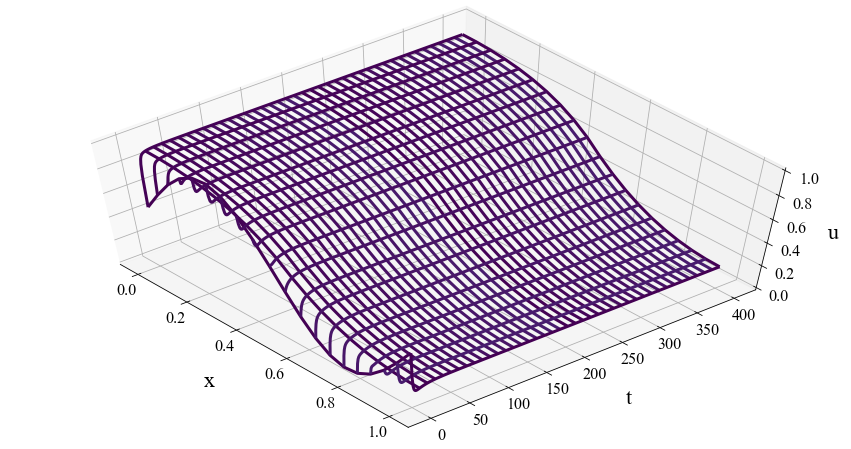

In [7]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111, projection = '3d')
color = plt.cm.viridis(np.arange(N)) 
surf = ax.plot_wireframe(X, Y, flow.T, rstride = 10, cstride = 1,\
                         alpha = None, antialiased = True, linewidth = 3)
ax.view_init(60, -40)
plt.draw()
surf.set_edgecolors(color)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

ax.tick_params(which = 'both', labelsize = 16)
ax.set_xlabel('x', size = 22, labelpad = 30)
ax.set_ylabel('t', size = 22, labelpad = 30)
ax.set_zlabel('u', size = 22, labelpad = 10)
ax.set_zlim([0,1])
plt.show()

### Propagation with randomly generated coefficients

But let's go back: the PSBC initialize these coeficients in a randomized fashion. Let's see more or less what it looks like

In [8]:
N = 1
init = Initialize_parameters()
prop = Propagate()
dt_vec = np.array([.1,.3,.57,1.5,3,4])
dt, eps, Nx, Nt, dx = .1, 0, N, 20, 1
ptt_cardnlty, weights_k_sharing = Nx, Nt

In [9]:
param = init.dictionary(N, eps, dt, dx, Nt, ptt_cardnlty, weights_k_sharing)

for i in range(param["Nt"]): param["alpha_x_t"][:,i] = np.random.uniform(0,1)

n_points = 10    
V_0 = np.reshape(1/n_points * np.arange(0, n_points + 1), (1, -1))
flow, waterfall, time = prop.forward(V_0, param, waterfall_save = True , Flow_save = True)

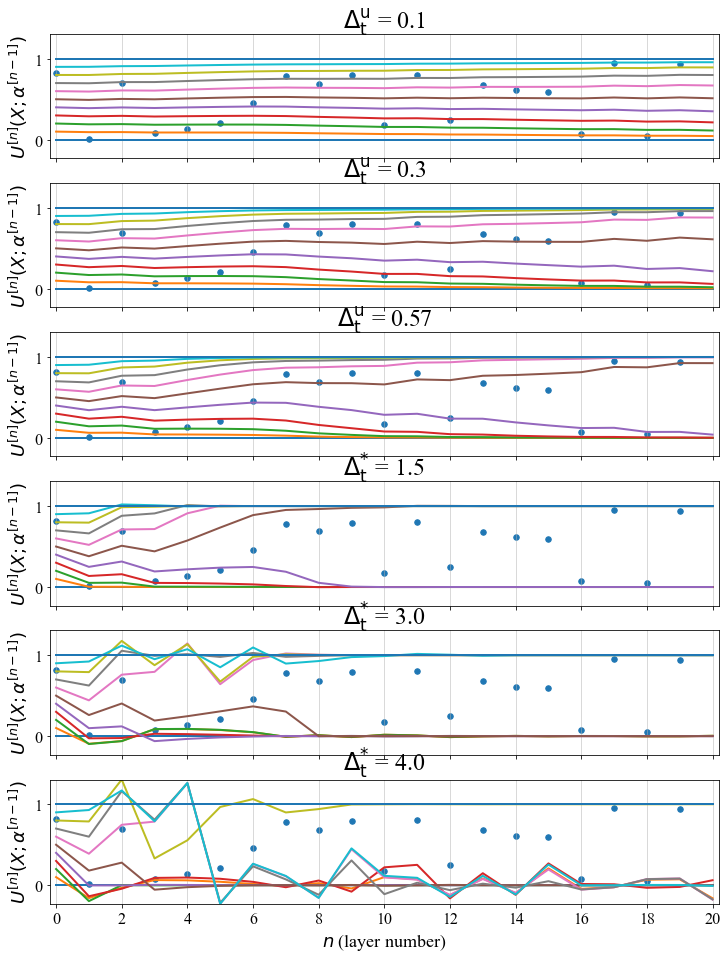

In [10]:
# Setting a random seed for reproduction of graph, set np.random.seed(123)
np.random.seed(8123)
A = np.reshape(np.random.uniform(0,1, size = Nt), (1,-1))
x_ticks = np.arange(0,21,2)
n_points = 10    
V_0 = np.reshape(1/n_points*np.arange(0,n_points+1), (1,-1))

fig, ax = plt.subplots(
    ncols = 1, nrows = 6, figsize = (12,16), sharex = True, gridspec_kw = {'wspace':20}
)

m, M = 0,1

for i in range(6):
    dt = dt_vec[i]
    param = init.dictionary(N, eps, dt, dx, Nt, ptt_cardnlty, weights_k_sharing)
    param["alpha_x_t"] = A

    flow, waterfall, time = prop.forward(V_0, param, waterfall_save = True , Flow_save = True)
    
    m, M = min(m, np.min(flow)), max(M, np.max(flow))
    
    if i <3: ax[i].set_title(r"$\Delta_{\mathrm{t}}^{\mathrm{u}}$ = " + str(dt))
    else: ax[i].set_title(r"$\Delta_{\mathrm{t}}^{\mathrm{*}}$ = " + str(dt))
        
    ax[i].set_xlim([-.2,20.2])
    ax[i].set_ylabel(r"$U^{[n]}(X;\alpha^{[n-1]})$")
    ax[i].set_xticks(x_ticks)
    
    if i == 5: ax[i].set_xlabel(r"$n$ (layer number)")

    ax[i].scatter(np.arange(0,param["alpha_x_t"].shape[1]),param["alpha_x_t"].T, marker='o',s = 30)
    ax[i].plot(flow[0,:].T)
    ax[i].grid(True, axis = 'x')
    
## Adjust height
for i in range(6): ax[i].set_ylim([m,M])

plt.show()

<h3><center> Applying the PSBC model to some toy problems</center></h3>

As we did in the paper, we shall present the model in a simple toy problem, for illustrative purposes. We shall apply the PSBC later on to the MNIST dataset, where it has been trained.

### The 1D Rectangular box problem

We shall work with a simple 1D model (the rectangular box problem), as the one used in the paper.

In [11]:
folder = "Statistics/MNIST/"
with open(folder + "parameters_MNIST_Neumann.p", 'rb') as fp: data = pickle.load(fp)

In [12]:
### GENERATE DATA
gamma, N_data = .2, 2000
X = np.reshape(np.random.uniform(0, 1, N_data),(1, -1))
Y = np.array(X >= gamma, np.int, ndmin = 2)

### SPLIT DATA FOR CROSS VALIDATION
A, B, C, D = train_test_split(X.T, Y.T, test_size = 0.2)
#### We shall save one individual per column. We need to change that upon reading the csv later on
X_train, X_test, Y_train, Y_test = A.T, B.T, C.T, D.T

In this model, the data has to satisfy features dimension X number of elements in the sample

In [13]:
np.shape(X_train)

(1, 1600)

Now let's define the parameters

In [14]:
learning_rate = (.1,.08,.93)
patience = float("inf")
sigma = .1
drop_SGD = 0.95  # See  docstring of class "Binary_phase_separation" for further information
epochs, dt, dx, eps, Nx, Nt = 600, .1, 1, 0, 1, 20
weights_k_sharing = Nt
ptt_cardnlty = 1
batch_size = None
subordinate, save_parameter_hist, orthodox_dt, with_phase = True, True, True, True

and initialize the model

In [15]:
Init = Initialize_parameters()   

data = Init.dictionary(Nx, eps, dt, dx, Nt, ptt_cardnlty, weights_k_sharing, sigma = sigma )
data.update({'learning_rate' :  learning_rate, 'epochs' :  epochs,\
             'subordinate' :  subordinate,"patience" : patience,\
             'drop_SGD' : drop_SGD,"orthodox_dt" : orthodox_dt,'with_phase' : with_phase,
             "batch_size" : batch_size, "save_parameter_hist" : save_parameter_hist })

We are finally ready to train the model. We do so using the class Binary_Phase_Separation

In [16]:
Model = Binary_Phase_Separation()

Of which you can learn more about by typing 

In [17]:
print(Model.__doc__)

    
    This is the main class  of the Phase Separation Binary Classifier (PSBC).
    With its methods one can, aong other things, train the model and 
    predict classifications (once the model has been trained).
    


If the above is not enough you can do this:

In [18]:
print(help(Model))

Help on Binary_Phase_Separation in module binary_phase_separation object:

class Binary_Phase_Separation(builtins.object)
 |  Binary_Phase_Separation(cost=None, par_U_model=None, par_P_model=None, par_U_wrt_epochs=None, par_P_wrt_epochs=None)
 |  
 |  This is the main class  of the Phase Separation Binary Classifier (PSBC).
 |  With its methods one can, aong other things, train the model and 
 |  predict classifications (once the model has been trained).
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cost=None, par_U_model=None, par_P_model=None, par_U_wrt_epochs=None, par_P_wrt_epochs=None)
 |      Class initializer. 
 |      
 |      Parameters
 |      ----------
 |      cost : {bool, True}, optional
 |      par_U_model : {dictionary, None}, optional
 |          Dictionary containing initialization parameters for the U component
 |          of the PSBC.
 |      par_P_model : {dictionary, None}, optional
 |          Dictionary containing initialization parameters for the P com

But this is maybe too much. So, let's say that you just want to know about how to train. You can get information only about that method

In [19]:
print(Model.train.__doc__)


        'train' method.

        This method trains the PSBC model with a given set of parameters and 
        data.
        
        Parameters
        ----------
        X : numpy.ndarray of size Nx X N_data
            Matrix with features. 
        Y : numpy.ndarray of size 1 X N_data
            Matrix with labels. 
        X_test : numpy.ndarray of size Nx X N_data_test
            Matrix with features. 
        Y_test : numpy.ndarray of size 1 X N_data_test
            Matrix with labels. 
        learning_rate : float or tuple
            If Tuple with three elements (a,b,c), 
            these numbers  parametrize the learning rate decay.
        dt : float
            Mesh grid size of time discretization 
        dx : float
            Mesh grid size of spatial discretization.  
        layers : int
            Number o f layers. 
        weights_K_sharing : int
            Number of successive layers that are sharing their weights.
        eps : {float, 0}, optional
      

The method that we want is train. So, we do 

In [20]:
Model.train(
    X_train, Y_train, X_train, Y_train, learning_rate, dt, dx, Nt,\
        weights_k_sharing, eps = eps, epochs = epochs, \
        subordinate = subordinate, with_phase = with_phase,\
        drop_SGD = drop_SGD, sigma = sigma,\
        orthodox_dt = orthodox_dt, print_every = 300,\
            save_parameter_hist = save_parameter_hist
)


 epoch : 0 cost 0.11494985702898435

 accuracy : 0.70375

 epoch : 300 cost 0.022553932287346947

 accuracy : 0.9775


If you want to take a look at how the cost function behaves over epochs, you can plot it as


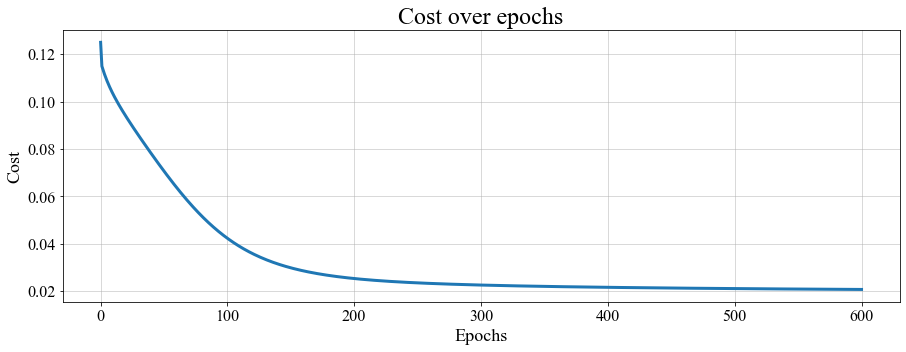

In [21]:
cost_over_epochs = Model.cost

x = np.arange(len(cost_over_epochs))
f, ax = plt.subplots(figsize = (15,5))
ax.plot(x, cost_over_epochs, lw = 3)

ax.set_title("Cost over epochs")
ax.set_ylabel("Cost")
ax.set_xlabel("Epochs")
ax.grid(True)
plt.show()

And if you want to take a look at the behavior of the set $\mathscr{P}_{\alpha}$ you can also do. Just type

In [22]:
diameter_history = Model.diameters_hist

which will give you a dictionary with two keys: "U" and "P"

In [23]:
diameter_history.keys()

dict_keys(['P', 'U'])

They concern the behavior of trainable weights for the U variable, and for the P variable. They can be plotted as 

No handles with labels found to put in legend.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


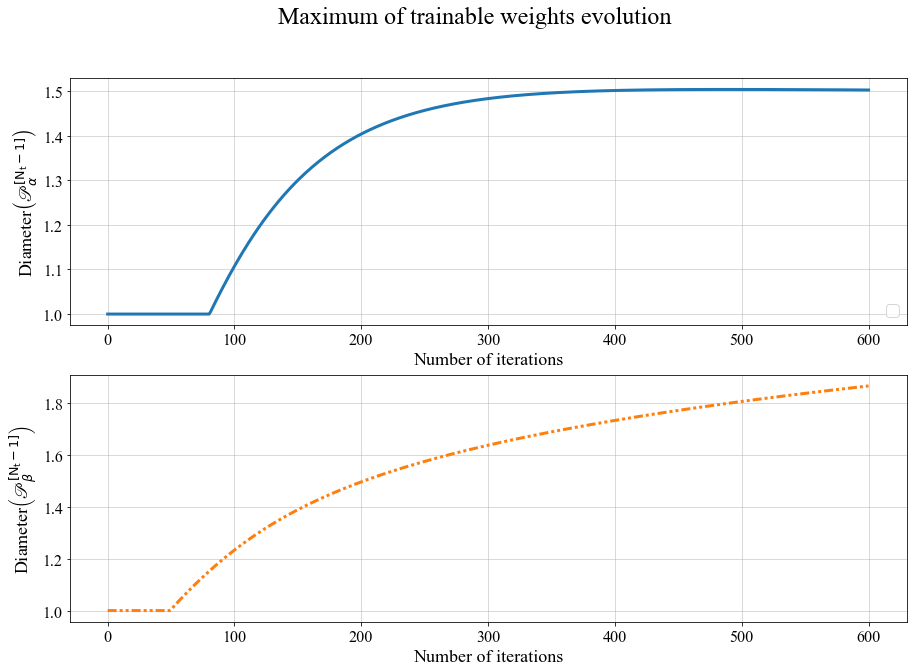

In [24]:
fig, ax = plt.subplots( nrows = 2, figsize = (15,10))

colors = pl.cm.tab20(np.linspace(0,1,11))

ax[0].plot(
    diameter_history["U"],   linestyle = '-', lw = 3,\
    label = None, color = colors[0] 
)
ax[1].plot(
    diameter_history["P"],   linestyle = (0,(3,1,1,1,1,1)), lw = 3,\
    label = None, color = colors[1]
)

fig.suptitle("Maximum of trainable weights evolution")
ax[0].legend(loc = 4, fontsize = 16, ncol = 3)
ax[0].set_ylabel(r'Diameter$\left(\mathscr{P}_{\alpha}^{[\mathrm{N_t}-1]}\right)$')
ax[0].set_xlabel('Number of iterations')
ax[0].grid(True)
ax[1].set_ylabel(r'Diameter$\left(\mathscr{P}_{\beta}^{[\mathrm{N_t}-1]}\right)$')
ax[1].set_xlabel('Number of iterations')
ax[1].grid(True)
plt.show()

This is the typical behavior of these quantities. Note that they remain constant (equal to 1) up to a certain point, and then they grow in a logarithmic shape. Note that the point of departure from the value 1 is different for both variables. That's because they have a separate dynamics, and are allowed to vary independently.


Last, since we are saving parameters (setting the variable "save_parameter_hist = True") we can see the behvarior of the accuracy throughout epochs: we are saving all the parameters in the model at each epoch. We wemark that is applications it is better to set "save_parameter_hist = False" in order to save memory 

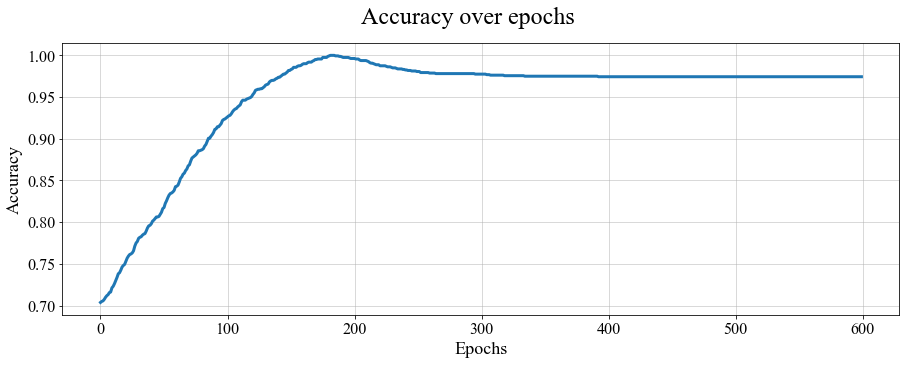

In [25]:
accuracies_fnt = Model.accuracies_hist
x = np.arange(len(accuracies_fnt))

## Plotting
f, ax = plt.subplots(figsize = (15,5))
ax.plot(x, accuracies_fnt, lw = 3)
f.suptitle("Accuracy over epochs")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
ax.grid(True)
plt.show()

Note the the model peaks (reaches a point of high accuracy) before the final epoch. This natural "deterioration" is what lead researchers to design Early Stopping techniques. We can in fact know what that epoch was by typing

In [26]:
Model.best_epoch

array(181)

Whose value was

In [27]:
Model.best_accuracy

array(1.)

that is, 100\% accuracy.

If you want to retrieve the model parameters at such an epoch you just need to type

In [28]:
best_P , best_U = Model.best_par_P_model, Model.best_par_U_model

which will give the value of the parameters used when the model achieved its best performance.

In [29]:
number_tests = Model.par_U_model["epochs"]

accuracy_train, accuracy_test = [] , []
for j in range(number_tests - 1):

    _, aux_train, accuracy_train_now =\
        Model.predict_and_accuracy(
        X_train,Y_train, Model.par_U_wrt_epochs[str(j)], Model.par_P_wrt_epochs[str(j)],\
        subordinate = subordinate,with_phase = with_phase)
    _, aux_test, accuracy_test_now =\
        Model.predict_and_accuracy(
        X_test, Y_test, Model.par_U_wrt_epochs[str(j)], Model.par_P_wrt_epochs[str(j)],\
        subordinate = subordinate, with_phase = with_phase)

    # Accuracies
    accuracy_train.append(accuracy_train_now)
    accuracy_test.append(accuracy_test_now)

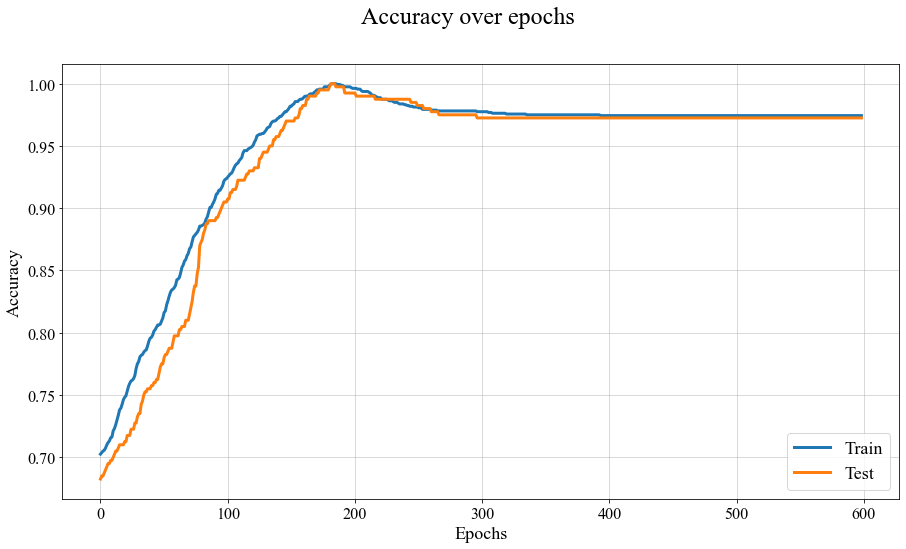

In [30]:
x = np.arange(len(accuracy_train))

## Plotting
f, ax = plt.subplots(figsize = (15,8))
plt.plot(x, accuracy_train, lw = 3, label = "Train")
plt.plot(x, accuracy_test, lw = 3, label = "Test")
f.suptitle("Accuracy over epochs")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
ax.legend(loc = 4)
ax.grid(True)
plt.show()

<h1> <center> The MNIST dataset</center> </h1>

In [31]:
#########################################################################
### READ MNIST DATASET TO PANDAS DATAFRAME AND THEN TO CSV FILE
#########################################################################
data_train_MNIST = pd.read_csv('Examples/data_train_normalized_MNIST.csv')
data_test_MNIST = pd.read_csv('Examples/data_test_normalized_MNIST.csv')

In [32]:
X_train_MNIST = (data_train_MNIST.iloc[:,:-1]).to_numpy()
Y_train_MNIST = np.reshape(data_train_MNIST.iloc[:,-1].to_numpy(), (1,-1))
X_test_MNIST = (data_test_MNIST.iloc[:,:-1]).to_numpy()
Y_test_MNIST = np.reshape(data_test_MNIST.iloc[:,-1].to_numpy(), (1,-1))

X_train_MNIST, X_test_MNIST = X_train_MNIST.T , X_test_MNIST.T

In [33]:
print(X_test_MNIST.shape, Y_test_MNIST.shape)

(784, 2956) (1, 2956)


See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

In [34]:
(X_train_MNIST.min(axis = 0)[:5], X_train_MNIST.max(axis = 0)[:5]),\
(X_test_MNIST.min(axis = 0)[:5], X_test_MNIST.max(axis = 0)[:5])

((array([0.5, 0.5, 0.5, 0.5, 0.5]), array([0.7, 0.7, 0.7, 0.7, 0.7])),
 (array([0.5, 0.5, 0.5, 0.5, 0.5]), array([0.7, 0.7, 0.7, 0.7, 0.7])))

In [35]:
print(
    "Train, 0:\t",len(np.squeeze(np.where(Y_train_MNIST == 0))[1,:])/Y_train_MNIST.shape[1],\
      "\nTrain, 1: \t",len(np.squeeze(np.where(Y_train_MNIST == 1))[1,:])/Y_train_MNIST.shape[1]
)

print(
    "Test, 0:\t",len(np.squeeze(np.where(Y_test_MNIST == 0))[1,:])/Y_test_MNIST.shape[1],\
      "\nTest, 1: \t",len(np.squeeze(np.where(Y_test_MNIST == 1))[1,:])/Y_test_MNIST.shape[1]
)

Train, 0:	 0.46354871447902574 
Train, 1: 	 0.5364512855209743
Test, 0:	 0.4810554803788904 
Test, 1: 	 0.5189445196211097


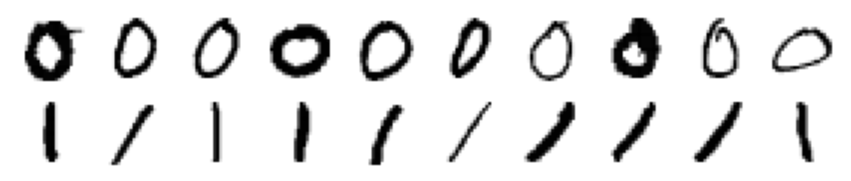

In [36]:
where_0 = np.squeeze(np.where(Y_train_MNIST == 0))[1,:10]
where_1 = np.squeeze(np.where(Y_train_MNIST == 1))[1,:10]

plt.figure(figsize = (15,10))

pick = np.asarray(where_0)
zero_images = np.array([], dtype = np.int64).reshape(28,0)
images = [np.reshape(X_train_MNIST[:,pick[image_index]], (28,28)) for image_index in range(10) ]
for image in images:
    zero_images = np.concatenate([zero_images,image], axis = 1)

pick = np.asarray(where_1)
one_images = np.array([], dtype = np.int64).reshape(28,0)
images = [np.reshape(X_train_MNIST[:,pick[image_index]], (28,28)) for image_index in range(10) ]
for image in images:
    one_images = np.concatenate([one_images,image], axis = 1)

both = np.concatenate([zero_images,one_images], axis = 0)    
plt.axis("off")

plt.imshow(both, cmap = "binary")
plt.show()

One can also visualize the trainable weights as heatmaps.

In [37]:
parent_folder = "Examples/"

## Non-subordinate ########################################################
sub_non_sub = {}
folder_now = parent_folder + "W1S-NS/simulation1/"

with open(folder_now + "Full_model_properties.p", 'rb') as fp: Full_model_properties = pickle.load(fp)

sub_non_sub["non" + "best_par_P"] = Full_model_properties["best_par_P_model"]
sub_non_sub["non" + "best_par_U"] = Full_model_properties["best_par_U_model"]

## Subordinate  ############################################################
parent_folder = "Examples/"
folder_now = parent_folder + "W1S-S/simulation1/"

with open(folder_now + "Full_model_properties.p", 'rb') as fp: Full_model_properties = pickle.load(fp)

sub_non_sub["sub" + "best_par_P"] = Full_model_properties["best_par_P_model"]
sub_non_sub["sub" + "best_par_U"] = Full_model_properties["best_par_U_model"]

## W1S-Nt8 ##################################################################
parent_folder = "Examples/"
folder_now = parent_folder + "W1S-Nt8/simulation1/"

with open(folder_now + "Full_model_properties.p", 'rb') as fp: Full_model_properties = pickle.load(fp)

sub_non_sub["kfold" + "best_par_P"] = Full_model_properties["best_par_P_model"]
sub_non_sub["kfold" + "best_par_U"] = Full_model_properties["best_par_U_model"]

In [38]:
import seaborn as sns
%matplotlib inline

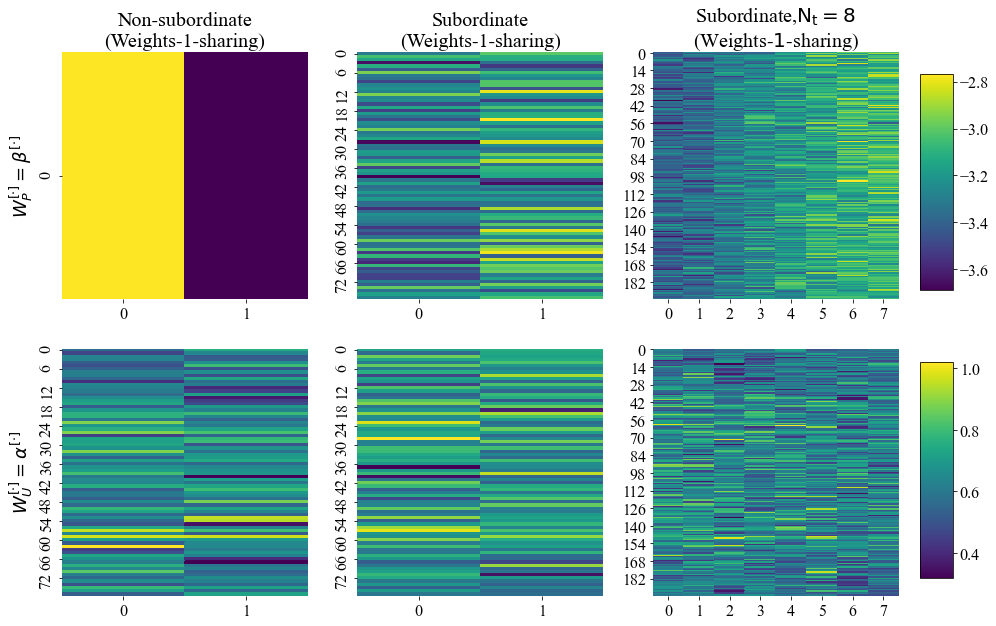

In [39]:
f, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10), constrained_layout = False)

list_sub  = ("non", "sub", "kfold")
list_sub_big  = ("Non-subordinate\n(Weights-1-sharing)",\
                 "Subordinate\n(Weights-1-sharing)",\
                 "Subordinate,"+ r"$\mathrm{N_t}=8$"+"\n"+r"(Weights-$1$-sharing)")

m_1 = np.min([sub_non_sub[list_sub[i] + "best_par_P"]["alpha_x_t"].min() for i in range(3)])
M_1 = np.max([sub_non_sub[list_sub[i] + "best_par_P"]["alpha_x_t"].max() for i in range(3)])

for i in range(3):
    Nx = sub_non_sub[list_sub[i] + "best_par_P"]["alpha_x_t"].shape[0]
    sub_non_sub[str(i) + "matrix"] = sub_non_sub[list_sub[i] + "best_par_P"]["alpha_x_t"]
    sns.heatmap(\
                sub_non_sub[str(i) + "matrix"],  ax = ax[0,i], vmin = m_1, vmax = M_1, cbar = False,\
                cmap = 'inferno'
               )
    pcm = ax[0,i].pcolormesh(sub_non_sub[str(i) + "matrix"])
    ax[0,i].set_title(list_sub_big[i], size = 20)

f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([.92, .55, .03, .3])
f.colorbar(pcm, cax = cbar_ax)
    
ax[0,0].set_ylabel(r"$W_P^{[\cdot]} = \beta^{[\cdot]}$",rotation=90, size = 18)


m_2 = np.min([sub_non_sub[list_sub[i] + "best_par_U"]["alpha_x_t"].min() for i in range(3)])
M_2 = np.max([sub_non_sub[list_sub[i] + "best_par_U"]["alpha_x_t"].max() for i in range(3)])

for i in range(3):
    Nx = sub_non_sub[list_sub[i] + "best_par_U"]["alpha_x_t"].shape[0]
    M = sub_non_sub[list_sub[i] + "best_par_U"]["alpha_x_t"]
    sub_non_sub[str(i) + "matrix"] = M
    
    sns.heatmap(M, ax = ax[1,i], vmin = m_2, vmax = M_2, cbar = False, cmap = 'inferno')
    pcM = ax[1,i].pcolormesh(sub_non_sub[str(i) + "matrix"])
    
cbar_ax2 = f.add_axes([.92, .15, .03, .3])
f.colorbar(pcM, cax = cbar_ax2)
ax[1,0].set_ylabel(r"$W_U^{[\cdot]} = \alpha^{[\cdot]}$", rotation = 90, size = 18)
plt.show()

<h1> <center> Retrieving some statistics</center> </h1>

In [40]:
parameters_MNIST_nondif, stats_folder_MNIST = {}, "Statistics/MNIST/"

with open(stats_folder_MNIST + "parameters_MNIST_nondif.p", 'rb') as fp: 
    parameters_MNIST_nondif = pickle.load(fp)

parameters_MNIST_Neumann, stats_folder_MNIST = {}, "Statistics/MNIST/"

with open(stats_folder_MNIST + "parameters_MNIST_Neumann.p", 'rb') as fp:
        parameters_MNIST_Neumann = pickle.load(fp)

parameters_MNIST_Periodic, stats_folder_MNIST = {}, "Statistics/MNIST/"

with open(stats_folder_MNIST + "parameters_MNIST_Periodic.p", 'rb') as fp:
        parameters_MNIST_Periodic = pickle.load(fp)

In [41]:
help(accuracies)

Help on function accuracies in module aux_fnts_for_jupyter_notebooks:

accuracies(parameters, name, accuracy_type, number_folders=10, number_simulations=10)
    This function is only used in the jupyter notebook for the MNIST dataset
    
    
    Parameters
    ----------
    parameters : dictionary
        Dictionary containing summary of data for some PSBC experiments.
    name : string
        Name of the keys of the dictionary "parameters" that we are studying, corresponding to a PSBC configuration.
    accuracy_type : string
        Either "best_accuracy_train" or "best_accuracy_test".
    number_folders : {int, 10}, optional
        Number of folders, where each folder corresponds of one value of the parameter being valued.
    number_simulations : {int, 10}, optional
        Number of simulations that were run with the same parameter, for statistical purposes.
    
    Returns
    -------
    A : matrix
        Matrix with all the accuracies of type accuracy_type, 
        wher

For more details about the code in the next plot, see Remark 1 (cell 20) in the jupyter-notebook **Notebook_PSBC_MNIST.ipynb**.

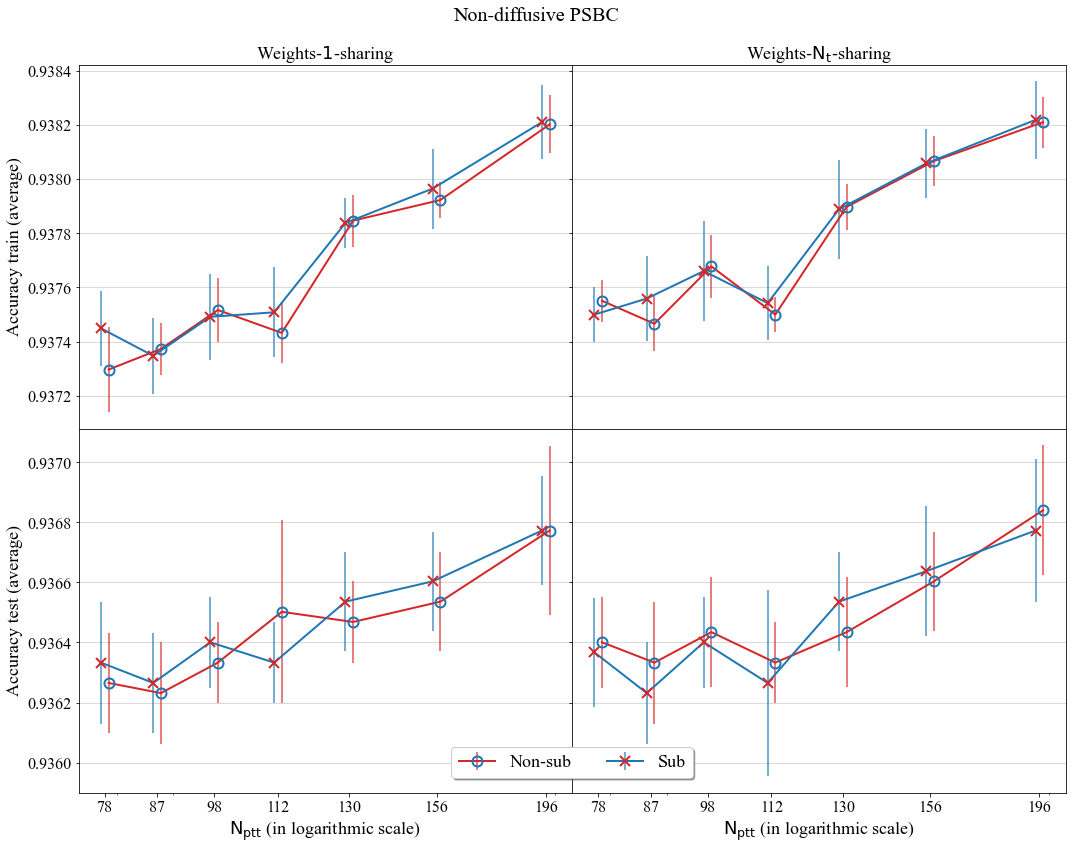

In [42]:
A_train_1NS, value_of_parameter_varying = accuracies (
    parameters_MNIST_nondif, "W1S-NS", "best_accuracy_train")
value_of_parameter_varying = value_of_parameter_varying[::-1]
average_train_1NS, stdev_train_1NS =\
np.mean(A_train_1NS, axis = 1)[::-1], np.std(A_train_1NS, axis = 1)[::-1]

A_train_1S, _ = accuracies (
    parameters_MNIST_nondif, "W1S-S", "best_accuracy_train")
average_train_1S, stdev_train_1S = np.mean(A_train_1S, axis = 1)[::-1], np.std(A_train_1S, axis = 1)[::-1]

A_train_NS, _ = accuracies (
    parameters_MNIST_nondif, "WNtS-NS", "best_accuracy_train")
average_train_NS, stdev_train_NS = np.mean(A_train_NS, axis = 1)[::-1], np.std(A_train_NS, axis = 1)[::-1]

A_train_S, _ = accuracies (
    parameters_MNIST_nondif, "WNtS-S", "best_accuracy_train")
average_train_S, stdev_train_S = np.mean(A_train_S, axis = 1)[::-1], np.std(A_train_S, axis = 1)[::-1]

colors = pl.cm.tab10(np.linspace(0,1,9))
colors_markers = pl.cm.tab10(np.linspace(0,1,9))

# Parameters using during pltting
col_NS, mk_NS, alpha_for_all, L, T  = 0, 1, 0.6, -3, .008
value_of_parameter_varying = np.asarray(value_of_parameter_varying)

fig,ax = plt.subplots(
     nrows =  2, ncols = 2, figsize = (15,12), sharey='row', sharex = 'col',\
   gridspec_kw = {'wspace':0,'hspace':0},    constrained_layout = False
)

markers, caps, bars = ax[0,0].errorbar(
    (1 + T)*value_of_parameter_varying[:L], average_train_1NS[:L], marker = 'o',\
    yerr = stdev_train_1NS[:L], errorevery = 1, linestyle = '-',\
    label = "Non Sub", color = colors[col_NS+3],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS-1]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[0,0].errorbar(
    (1/(1 + T))*value_of_parameter_varying[:L], average_train_1S[:L], marker = 'x',\
    yerr = stdev_train_1S[:L], errorevery = 1, linestyle = '-',\
    label = "Sub", color = colors[col_NS],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS+2]    
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[0,1].errorbar(
    (1 + T)*value_of_parameter_varying[:L], average_train_NS[:L], marker = 'o',\
    yerr = stdev_train_NS[:L], errorevery = 1, linestyle = '-',\
    label = "Non Sub", color = colors[col_NS+3],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS-1]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[0,1].errorbar(
    (1/(1 + T))*value_of_parameter_varying[:L], average_train_S[:L], marker = 'x',\
    yerr = stdev_train_S[:L], errorevery = 1, linestyle = '-',\
    label = "Sub", color = colors[col_NS],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS+2]    
)
[bar.set_alpha(alpha_for_all) for bar in bars]

A_test_1NS, _ = accuracies (parameters_MNIST_nondif, "W1S-NS", "best_accuracy_test")
average_test_1NS, stdev_test_1NS = np.mean(A_test_1NS, axis = 1)[::-1], np.std(A_test_1NS, axis = 1)[::-1]

A_test_1S, _ = accuracies (parameters_MNIST_nondif, "W1S-S", "best_accuracy_test")
average_test_1S, stdev_test_1S = np.mean(A_test_1S, axis = 1)[::-1], np.std(A_test_1S, axis = 1)[::-1]

A_test_NS, _ = accuracies (parameters_MNIST_nondif, "WNtS-NS", "best_accuracy_test")
average_test_NS, stdev_test_NS = np.mean(A_test_NS, axis = 1)[::-1], np.std(A_test_NS, axis = 1)[::-1]

A_test_S, _ = accuracies (parameters_MNIST_nondif, "WNtS-S", "best_accuracy_test")
average_test_S, stdev_test_S = np.mean(A_test_S, axis = 1)[::-1], np.std(A_test_S, axis = 1)[::-1]

markers, caps, bars = ax[1,0].errorbar(
    (1 + T)*value_of_parameter_varying[:L], average_test_1NS[:L], marker = 'o', \
    yerr = stdev_test_1NS[:L], errorevery = 1, linestyle = '-',\
    label = "Non Sub", color = colors[col_NS+3],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS-1]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[1,0].errorbar(
    (1/(1 + T))*value_of_parameter_varying[:L], average_test_1S[:L], marker = 'x',\
    yerr = stdev_test_1S[:L], errorevery = 1,  linestyle = '-',\
    label = "Sub", color = colors[col_NS],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS+2]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[1,1].errorbar(
    (1 + T)*value_of_parameter_varying[:L], average_test_NS[:L], marker = 'o', \
    yerr = stdev_test_NS[:L], errorevery = 1, linestyle = '-',\
    label = "Non-sub", color = colors[col_NS+3],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS-1]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

markers, caps, bars = ax[1,1].errorbar(
    (1/(1 + T))*value_of_parameter_varying[:L], average_test_S[:L], marker = 'x',\
    yerr = stdev_test_S[:L], errorevery = 1,  linestyle = '-',\
    label = "Sub", color = colors[col_NS],\
    fillstyle = 'none', markeredgecolor = colors_markers[mk_NS+2]
)
[bar.set_alpha(alpha_for_all) for bar in bars]

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].grid(axis = "y")
        ax[i,j].set_xscale('log') 
        ax[i,j].set_xticks(np.asarray(value_of_parameter_varying[:L]))
        ax[i,j].tick_params("x")
        ax[i,j].get_xaxis().set_major_formatter(ScalarFormatter())
        ax[i,j].xaxis.set_minor_formatter(plt.matplotlib.ticker.NullFormatter())

ax[0,0].set_title(r"Weights-$1$-sharing", size = 18)  
ax[0,1].set_title(r"Weights-$\mathrm{N_t}$-sharing", size = 18)  
ax[0,0].set_ylabel("Accuracy train (average)")   
ax[1,0].set_ylabel("Accuracy test (average)")

ax[1,0].set_xlabel(r"$\mathrm{N_{ptt}}$ (in logarithmic scale)")
ax[1,1].set_xlabel(r"$\mathrm{N_{ptt}}$ (in logarithmic scale)")

chartBox = ax[1,1].get_position()
ax[1,1].set_position([chartBox.x0, chartBox.y0, chartBox.width*0.2, chartBox.height])
ax[1,1].legend(loc = 'upper center', bbox_to_anchor = (0, 0.15), shadow = True, ncol = 4)

fig.set_tight_layout({'rect': [0, 0, 1, 0.95]})
fig.suptitle("Non-diffusive PSBC", size = 20)
plt.show()

Or in case you want to see the evolution of the maximum over epochs, for Periodic PSBC with Nt =1

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


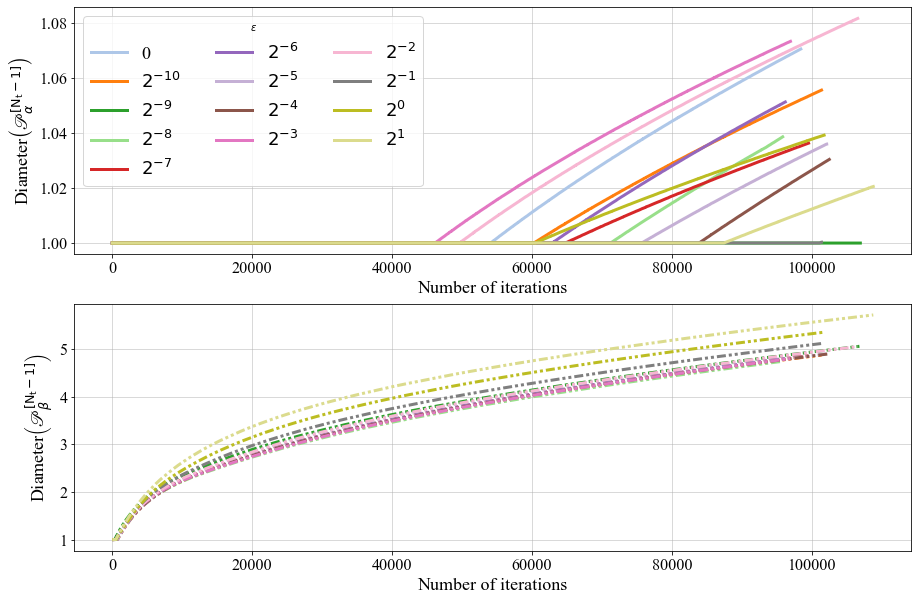

In [43]:
fig, ax = plt.subplots(nrows = 2, figsize = (15,10))

_, value_of_parameter_varying = accuracies (
    parameters_MNIST_Periodic, "Per_W1S-Nt2", "best_accuracy_train", number_folders = 13)

colors = pl.cm.tab20(np.linspace(0,1,16))

def test_label_value_of_parameter_varying(x):
    if x == 0:
        return "0"
    j = int(np.ceil(np.log2(x))) 
    return r'$2^{{{0}}}$'.format(j)

param = parameters_MNIST_Periodic["Per_W1S-Nt8"]
for i in range(1, 14):
    param_now = param[str(i)]
    diam_hist_now = param_now['diam_hist']
    ax[0].plot(diam_hist_now["U"],   linestyle = '-', lw = 3,\
               label = str(test_label_value_of_parameter_varying(value_of_parameter_varying[i-1])),\
               color=colors[i] )
    ax[1].plot(diam_hist_now["P"], linestyle = (0,(3,1,1,1,1,1)), lw = 3,\
               label = str(test_label_value_of_parameter_varying(value_of_parameter_varying[i-1])),\
               color = colors[i])

ax[0].legend(loc = 2, fontsize = 16, ncol = 3)
ax[0].set_ylabel(r'Diameter$\left(\mathscr{P}_{\alpha}^{[\mathrm{N_t}-1]}\right)$')
ax[0].set_xlabel('Number of iterations')
ax[0].grid(True)

ax[0].legend(loc = 2,  ncol = 3, title = r"$\varepsilon$")
plt.rcParams["legend.title_fontsize"] = 20
plt.rcParams["legend.columnspacing"] = .8

ax[1].set_ylabel(r'Diameter$\left(\mathscr{P}_{\beta}^{[\mathrm{N_t}-1]}\right)$')
ax[1].set_xlabel('Number of iterations')
ax[1].grid(True)
plt.show()

Or one could draw some confusion matrices. For example., the confution matrix for a realization of the diffusive PSBC with Neumann BCs, weights-1-sharing, and Nt = 8 is given below

In [44]:
parent_folder = "Examples/"
folder_now = parent_folder + "W1S-Nt8/simulation1/"
with open(folder_now + "Full_model_properties.p", 'rb') as fp: Full_model_properties = pickle.load(fp)

In [45]:
best_predic_vector_test_now = np.squeeze(Full_model_properties["best_predic_vector_test"])
real_tags = np.squeeze(Y_test_MNIST)

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
conf_matrix_example = confusion_matrix(real_tags, best_predic_vector_test_now )

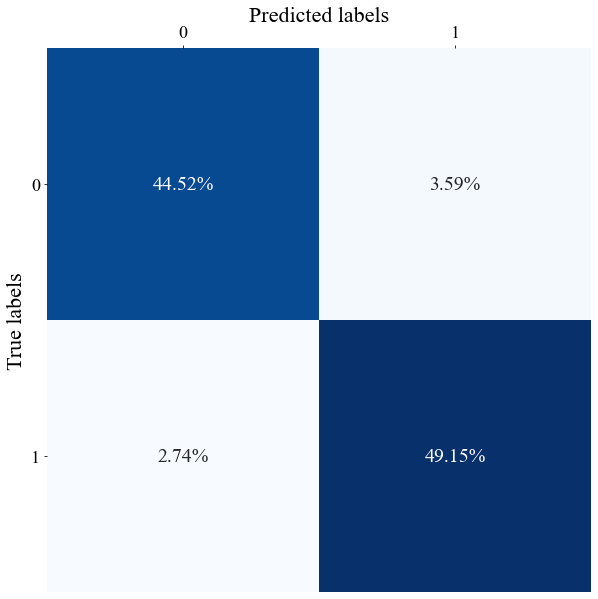

In [48]:
fig, axs = plt.subplots( nrows = 1,ncols = 1, figsize = (10, 10))

cax_test =   axs.matshow(conf_matrix_example, cmap = plt.cm.Blues)
axs = sns.heatmap(conf_matrix_example/np.sum(conf_matrix_example),\
                  annot = True, annot_kws={"size": 20},\
                  fmt='.2%', cmap = 'Blues', ax = axs, cbar = False)

plt.yticks(rotation = 0, fontsize = 18)
plt.xticks(fontsize = 18)
axs.xaxis.tick_top() # x axis on top
axs.xaxis.set_label_position('top')
axs.set_ylabel("True labels", fontsize = 22)
axs.set_xlabel("Predicted labels", fontsize = 22)
plt.show()

### Predicting my own hadwritten 0 and 1

So, as we have seen from the first example, this is a predictive  model (that we refer to as  PSBC) based on a reaction diffusion. In the second example we show the PSBC on a toy problem. As remarked extensively in the paper, we know that that is in fact quite a particular case of 1D problem where it performs well, because this is not expecited in general (see, in particular, Section 3.6 in the paper). 

To highlight the interplay between high-dimensionality of feature spaces and model compressibility, we have applied the model to the subset "0"-"1" of the MNIST database. To illustrate a bit more of the model's use and also play with the trainable weights, we will now predict the label for our own handwritten  numbers. One of the  original pictures is given below

In fact, I wrote 6 number - 3 zeros, 3 ones - for this notebook. If you read the first papers of LeCun et al. about the MNIST project, there is a description of the way pictures were taken, so that they look the way they do in cell 36 of this Notebook: the images had to be controlled for centralization, light contrast, etc. This is part of the statistical design, which I tried to follow as close as possible. 

I cropped the pictures using [GIMP](https://www.gimp.org), a free software for image manipulation: you take a picture, crop it, go to image, set it into grayscale. Then you can adjust for light contrast and other things. 

And that's it. Now, with the cropped, grayscale jpg in hands, you proceed as in the next cell. I show two examples below.

In [49]:
from PIL import Image

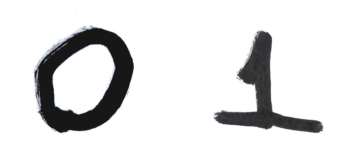

In [50]:
im_array0 = np.asarray(Image.open("figures/my_0.jpg"))
im_array1 = np.asarray(Image.open("figures/my_1.jpg"))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_array0, cmap='binary')
ax[1].imshow(im_array1, cmap='binary')
ax[0].axis(False)
ax[1].axis(False)
plt.show()

Now we reshape this pictures as a 28 x 28 matrix.

image has shape (28, 28)
image has shape (28, 28)
image has shape (28, 28)
image has shape (28, 28)
image has shape (28, 28)
image has shape (28, 28)


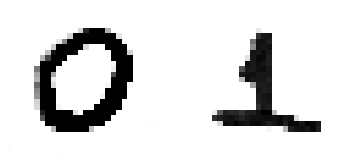

In [51]:
from PIL import Image

def create_MNIST_type_figure(name):
    """Convert jpg figure to a (28,28) numpy array"""
    image = Image.open(name).convert('L')
    image2 = image.resize((28,28))
    im2_as_array = 255- np.array(image2,  dtype=np.uint8)
    print("image has shape", im2_as_array.shape)

    return im2_as_array

my_0 = create_MNIST_type_figure("figures/my_0.jpg")
my_0_v2 = create_MNIST_type_figure("figures/my_0_v2.jpg")
my_0_v3 = create_MNIST_type_figure("figures/my_0_v3.jpg")
my_1 = create_MNIST_type_figure("figures/my_1.jpg")
my_1_v2 = create_MNIST_type_figure("figures/my_1_v2.jpg")
my_1_v3 = create_MNIST_type_figure("figures/my_1_v3.jpg")

fig, ax = plt.subplots(1,2)
ax[0].imshow(my_0, cmap='binary')
ax[1].imshow(my_1, cmap='binary')
ax[0].axis(False)
ax[1].axis(False)
plt.show()

Recall that we need to flatten these matrices,

In [52]:
my_0_for_psbc = my_0.flatten(order='C')
my_0_for_psbc_v2 = my_0_v2.flatten(order='C')
my_0_for_psbc_v3 = my_0_v3.flatten(order='C')
my_1_for_psbc = my_1.flatten(order='C')
my_1_for_psbc_v2 = my_1_v2.flatten(order='C')
my_1_for_psbc_v3  = my_1_v3.flatten(order='C')

and we can then combine all of them as columns in a single matrix.

In [53]:
combined_handwritten = \
np.c_[my_0_for_psbc, my_0_for_psbc_v2, my_0_for_psbc_v3, my_1_for_psbc, my_1_for_psbc_v2, my_1_for_psbc_v3]

Now we load a PSBC model 

In [54]:
with open("Examples/W1S-Nt8/simulation1/Full_model_properties.p", 'rb') as fp: load_mnist = pickle.load(fp)

psbc_testing = Binary_Phase_Separation()

In [55]:
prediction = psbc_testing.predict(combined_handwritten, load_mnist["best_par_U_model"],load_mnist["best_par_P_model"])
print(prediction)

[0 0 0 0 0 0]


/Users/rafaelmonteiro/Desktop/PSBC/All_cases/binary_phase_separation.py:475: RuntimeWarning: overflow encountered in multiply
  v = v +  dt * v * (1-v) * (v-alpha_x_t)
/Users/rafaelmonteiro/Desktop/PSBC/All_cases/binary_phase_separation.py:477: RuntimeWarning: invalid value encountered in matmul
  v = np.matmul(Minv,v)
/Users/rafaelmonteiro/Desktop/PSBC/All_cases/binary_phase_separation.py:1128: RuntimeWarning: invalid value encountered in greater
  keepdims = True, axis = 0))) > .5, dtype = np.int32)


This seems really bad... but don't be worried! You should not forget: we need to satisfy the normalization conditions!! In fact, we are very far from that:

In [56]:
np.max(combined_handwritten), np.min(combined_handwritten), combined_handwritten.shape

(255, 0, (784, 6))

So, let's normalize the data

In [57]:
init_data = Initialize_Data()

In [58]:
help(init_data)

Help on Initialize_Data in module binary_phase_separation object:

class Initialize_Data(builtins.object)
 |  This class preprocess the data, normalizing it.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Class initializer. No returned value.
 |  
 |  denormalize(self, Z, min_vals, max_vals, sigma=0.2)
 |      'denormalize' method.
 |      
 |      This method puts the data back to its original scale.
 |      Of the non-normalized data the method uses its  minimum value
 |      min_vals, its original maxum value max_vals, and sigma.
 |      The non-normalized data is transformed by
 |      
 |      A  = ( 1 / sigma ) * ( Z - .5 + sigma /2)
 |      
 |      and then Z_2 = min_vals + A * (max_vals - min_vals).
 |      
 |      Z_2 is the returned value.
 |      
 |      Parameters
 |      ----------
 |      
 |      Returns
 |      -------
 |      Non-normalized data 'A'.
 |      
 |      A : numpy.ndarray
 |  
 |  normalize(self, Z, sigma=0.2)
 |      'normalize' method.

So, the data get's normalized, but centered. By default, it gets rescaled in the range [0.4,0.6]. What we do then is: (i) we normalize it, then (ii) we add 0.1 to it.

In [59]:
combined_handwritten_for_psbc, _, _ = init_data.normalize(combined_handwritten)

In [60]:
combined_handwritten_for_psbc = 0.1+ combined_handwritten_for_psbc

In [61]:
np.max(combined_handwritten_for_psbc), np.min(combined_handwritten_for_psbc)

(0.7000000000000001, 0.5)

In [62]:
combined_handwritten_for_psbc.shape

(784, 6)

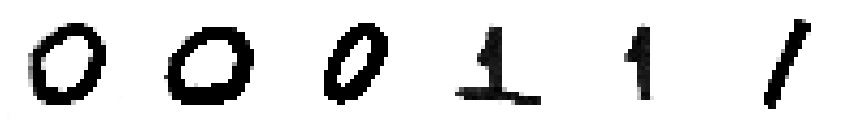

In [63]:
fig, ax = plt.subplots(1,6,figsize = (15,5))

for i in range(6):
    ax[i].imshow(np.reshape(combined_handwritten_for_psbc[:,i],(28,28)), cmap = 'binary')
    ax[i].axis("off")

In [64]:
for name in ["W1S-NS", "W1S-S", "WNtS-NS", "WNtS-S",\
            "W1S-Nt2", "W1S-Nt4", "W1S-Nt8",\
             "WNtS-Nt1","WNtS-Nt2", "WNtS-Nt4", "WNtS-Nt8",\
             "Per_W1S-Nt2", "Per_W1S-Nt4", "Per_W1S-Nt8",\
             "Per_WNtS-Nt1","Per_WNtS-Nt2", "Per_WNtS-Nt4", "Per_WNtS-Nt8"]:
            
    with open("Examples/"+name+"/simulation1/Full_model_properties.p", 'rb') as fp:
        load_mnist = pickle.load(fp)
    
    psbc_testing = Binary_Phase_Separation()
    prediction = \
    psbc_testing.predict(
        combined_handwritten_for_psbc,  load_mnist["best_par_U_model"], load_mnist["best_par_P_model"],\
        subordinate = load_mnist["best_par_U_model"]["subordinate"]
    )
    print("Model", name, " predicts", np.squeeze(prediction), "and correct is, [0 0 0 1 1 1]" )

Model W1S-NS  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model W1S-S  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-NS  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-S  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model W1S-Nt2  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model W1S-Nt4  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model W1S-Nt8  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-Nt1  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-Nt2  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-Nt4  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model WNtS-Nt8  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model Per_W1S-Nt2  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model Per_W1S-Nt4  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model Per_W1S-Nt8  predicts [0 0 0 0 1 1] and correct is, [0 0 0 1 1 1]
Model Per_WNtS-Nt1  predicts [0 0 0 

It is getting all correct, except for the 4th picture (which is in fact the way that I usually write, with that huge horizontal "foot"). 

### Where to read more 

There are quite a few places that you can read more about the Phase Separation Binary Classifier (PSBC), and also see further examples.

   1. I have posted a paper with all the mathematics behind the model. It is quite self contained, and you can "ignore"  most of the references that I do to other theories (like my comments about maximum principles in parabolic and elliptic PDEs, etc). There is a preprint currently available on arXiv at https://arxiv.org/abs/2009.02467
   2. There are many other examples of use in the jupyter-notebooks ([for 1D toy problem](), [for MNIST]())
   3. If you want to have access to the trainable examples I used, and to the computational statistics, you can either download the  files **PSBC_Examples.tar.gz** and **PSBC_computational_statistics.tar.gz** at the companion <a href="https://doi.org/10.5281/zenodo.4005131"> data repository</a> to this project at Zenodo.  There is also this script in this git-hub that you can use to download all you need automatically. You only need wget and tar to use it.
   4. In this Github you will also find a manual named **README.pdf** to the data in the repository, and also a script to download it (**download_PSBC.sh**). There are instructions on how to run the script in the **README.pdf** file. 
    
